In [57]:
%matplotlib inline
from pylab import *
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams.update({'font.size': 10})

cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
sns.reset_orig()

matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.facecolor'] = '#F8F8FF'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.axisbelow'] = True

matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 1.5
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1.

matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 1.5
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1.

print ('test')
def martians_year(ls, data):
    #### only looking at "second year"
    idx = np.where(ls==360)[0]
    if idx[0] != 0 and idx.size > 1:
        idx0 = idx[0]
        idx1 = idx[1]
        return data[idx0:idx1]
    elif idx[0] != 0 and idx.size == 1:
        idx1 = idx[0]
        return data[:idx1]
    elif idx[0] == 0:
        idx1 = idx[1]
        idx2 = idx[2]
        return data[idx1:idx2]

def martians_month(ls, data):
    temp = []
    for i in np.arange(0, 12):
        idx = np.where((ls>i*30)&(ls<(i+1)*30))[0]
        temp.append(data[idx].mean(axis=0))
    temp = np.array(temp)
    return temp

def zonal_plt_monthly(ydata, ls, data, title, level=12, norm=False, cmap=None):
    cmap=cmap or "viridis"
    from matplotlib.colors import SymLogNorm
    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14,12))
    for i, ax in enumerate(axes.flat):
        y = ydata[i][6:]
        
        #press2 = zonal_p[i-1].mean(axis=1)
        lat = np.linspace(-90, 90, 36) 
        temp_press = np.linspace(1e-2, 900, ydata[i].shape[0])[6:]
        
        lat, temp_press = np.meshgrid(lat, temp_press)
        
        d = data[i][6:]

        if norm:
            im = ax.contourf(lat, y, d, levels=level, cmap=cmap, norm=SymLogNorm(linthresh=1e5,vmin=np.min(d), vmax=np.max(d)))
            if not np.isnan(d).any():
                ax.contour(lat, y, d, levels=level, linewidths=0.5, colors='k', norm=SymLogNorm(linthresh=1e5,vmin=np.min(d), vmax=np.max(d)))
                
            ax.xaxis.set_minor_locator(AutoMinorLocator(4))
        else: 
            im = ax.contourf(lat, y, d, level, cmap=cmap, extend='both')
            for c in im.collections:
                c.set_edgecolor("face")
#             if not np.isnan(d).any():
#                 ax.contour(lat, y, d, level, linewidths=0.5, colors='k', extend='both')
        
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.set_title(r'{} LS {}-{}'.format((title), (i)*30, (i+1)*30))
        if i in [0,4,8]: ax.set_ylabel('Pressure [Pa]')
        if i in [8,9,10,11]: ax.set_xlabel('Latitude [$^\circ$]')
        ax.set_yscale('log')
        ax.set_ylim([900, 1])
        ax.set_xlim([-95, 95])
        ax.grid(True, which='both')
        
#        print ('Saving 1st cool shit')
    fig.tight_layout()
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, orientation='horizontal', pad=0.05)
#     plt.savefig('cl_am.pdf', format='pdf', bbox_inches='tight', dpi=400)

test


In [6]:
### from tqdm import tqdm
import scipy.interpolate as interpolate

filedir = './test_data/reduction_diag.r14p1/'

filepath = glob.glob(filedir + '*_PH.npy')[0]
ph = np.load(filepath)[:,:52]/(1000*3.41)

filepath = glob.glob(filedir + '*_P.npy')[0]
p = np.load(filepath)[:,:52]

filepath = glob.glob(filedir + '*_CL_AM.npy')[0]
cl_am = np.load(filepath).mean(axis=3)

filepath = glob.glob(filedir + '*_CL_PM.npy')[0]
print (filepath)
cl_pm = np.load(filepath).mean(axis=3)

filepath = glob.glob(filedir + '*_LS.npy')[0]
ls = np.load(filepath)[7::8]

filepath = glob.glob(filedir + '*_ls_AUX9.npy')
if filepath:
    filepath = filepath[0]
    ls_aux9 = np.load(filepath)

    idx = np.where(ls_aux9[0] == ls)[0]
    ls = ls[idx[0]:]
    p = p[idx[0]:]
    ph = ph[idx[0]:]

print (ph.shape, p.shape)
cl_am = martians_year(ls, cl_am)
cl_pm = martians_year(ls, cl_pm)
ph = martians_year(ls, ph[::8])
p = martians_year(ls, p[::8])
ls = martians_year(ls,ls)
print (ph.shape, p.shape, cl_am.shape)

dcladp = np.zeros_like(cl_am)
dpdz = np.zeros_like(cl_am)
dclpdp = np.zeros_like(cl_pm)
print('Calculating residual mean circulation ...')
for i in tqdm(np.arange(cl_am.shape[0])):
    for j in np.arange(cl_am.shape[2]):
        #tst = interpolate.CubicSpline(p[i,::-1,j], cl_am[i,::-1,j], bc_type='not-a-knot')
        #tst2 = interpolate.CubicSpline(ph[i,:,j], p[i,:,j], bc_type='not-a-knot')
        #dcladp[i,::-1,j] = tst(p[i,::-1,j], 1) * tst2(ph[i,:,j], 1)
        tst2 = interpolate.UnivariateSpline(ph[i,:,j], cl_am[i,:,j], k=2, s=0)
        dcladp[i,:,j] = tst2(ph[i,:,j], 1)

        tst = interpolate.UnivariateSpline(ph[i,:,j], cl_pm[i,:,j], k=2, s=0)
        dclpdp[i,:,j] = tst(ph[i,:,j], 1)

zonal_ph = martians_month(ls, ph)
zonal_p = martians_month(ls, p)
zonal_cl_am = martians_month(ls, dcladp )
zonal_cl_pm = martians_month(ls, dclpdp )


./test_data/reduction_diag.r14p1\wrfout_TAU_CL_PM.npy
(5969, 52, 36) (5969, 52, 36)
(669, 52, 36) (669, 52, 36) (669, 52, 36)
Calculating residual mean circulation ...


100%|███████████████████████████████████████████████████████████████████████████████| 669/669 [00:02<00:00, 293.78it/s]


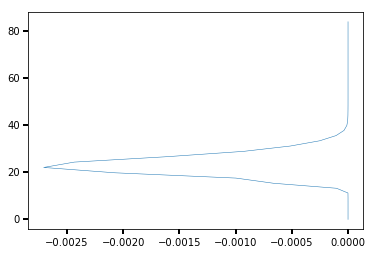

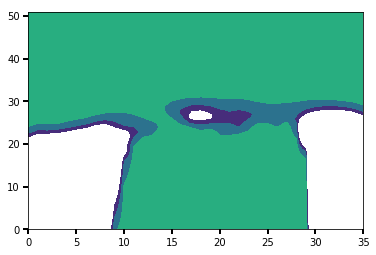

In [64]:
sl =[90,slice(None),18]
#plot(cl_am[sl],ph[sl])
#ylim(650,1) ; yscale('log')
plot(diff(cl_pm[sl])/diff(ph[sl]),convolve(ph[sl],[0.5,0.5],'valid'))
ic = interpolate.CubicSpline
#plot(ic(ph[sl],cl_pm[sl], bc_type='not-a-knot')(ph[sl],1),ph[sl])
#plot(dclpdp[sl],ph[sl])
#xlim(-1e-5,1e-5)
figure()
w=(ls>30)&(ls<60)
#plot(dclpdp[w,:,18].mean(axis=0),ph[w,:,18].mean(axis=0));
#plot(zonal_cl_pm[1,:,18],zonal_ph[1,:,18],ls=':')
#xlim(-1e-5,1e-5)
contourf(zonal_cl_pm[1],levels=arange(-0.0025,0.0025,0.001))

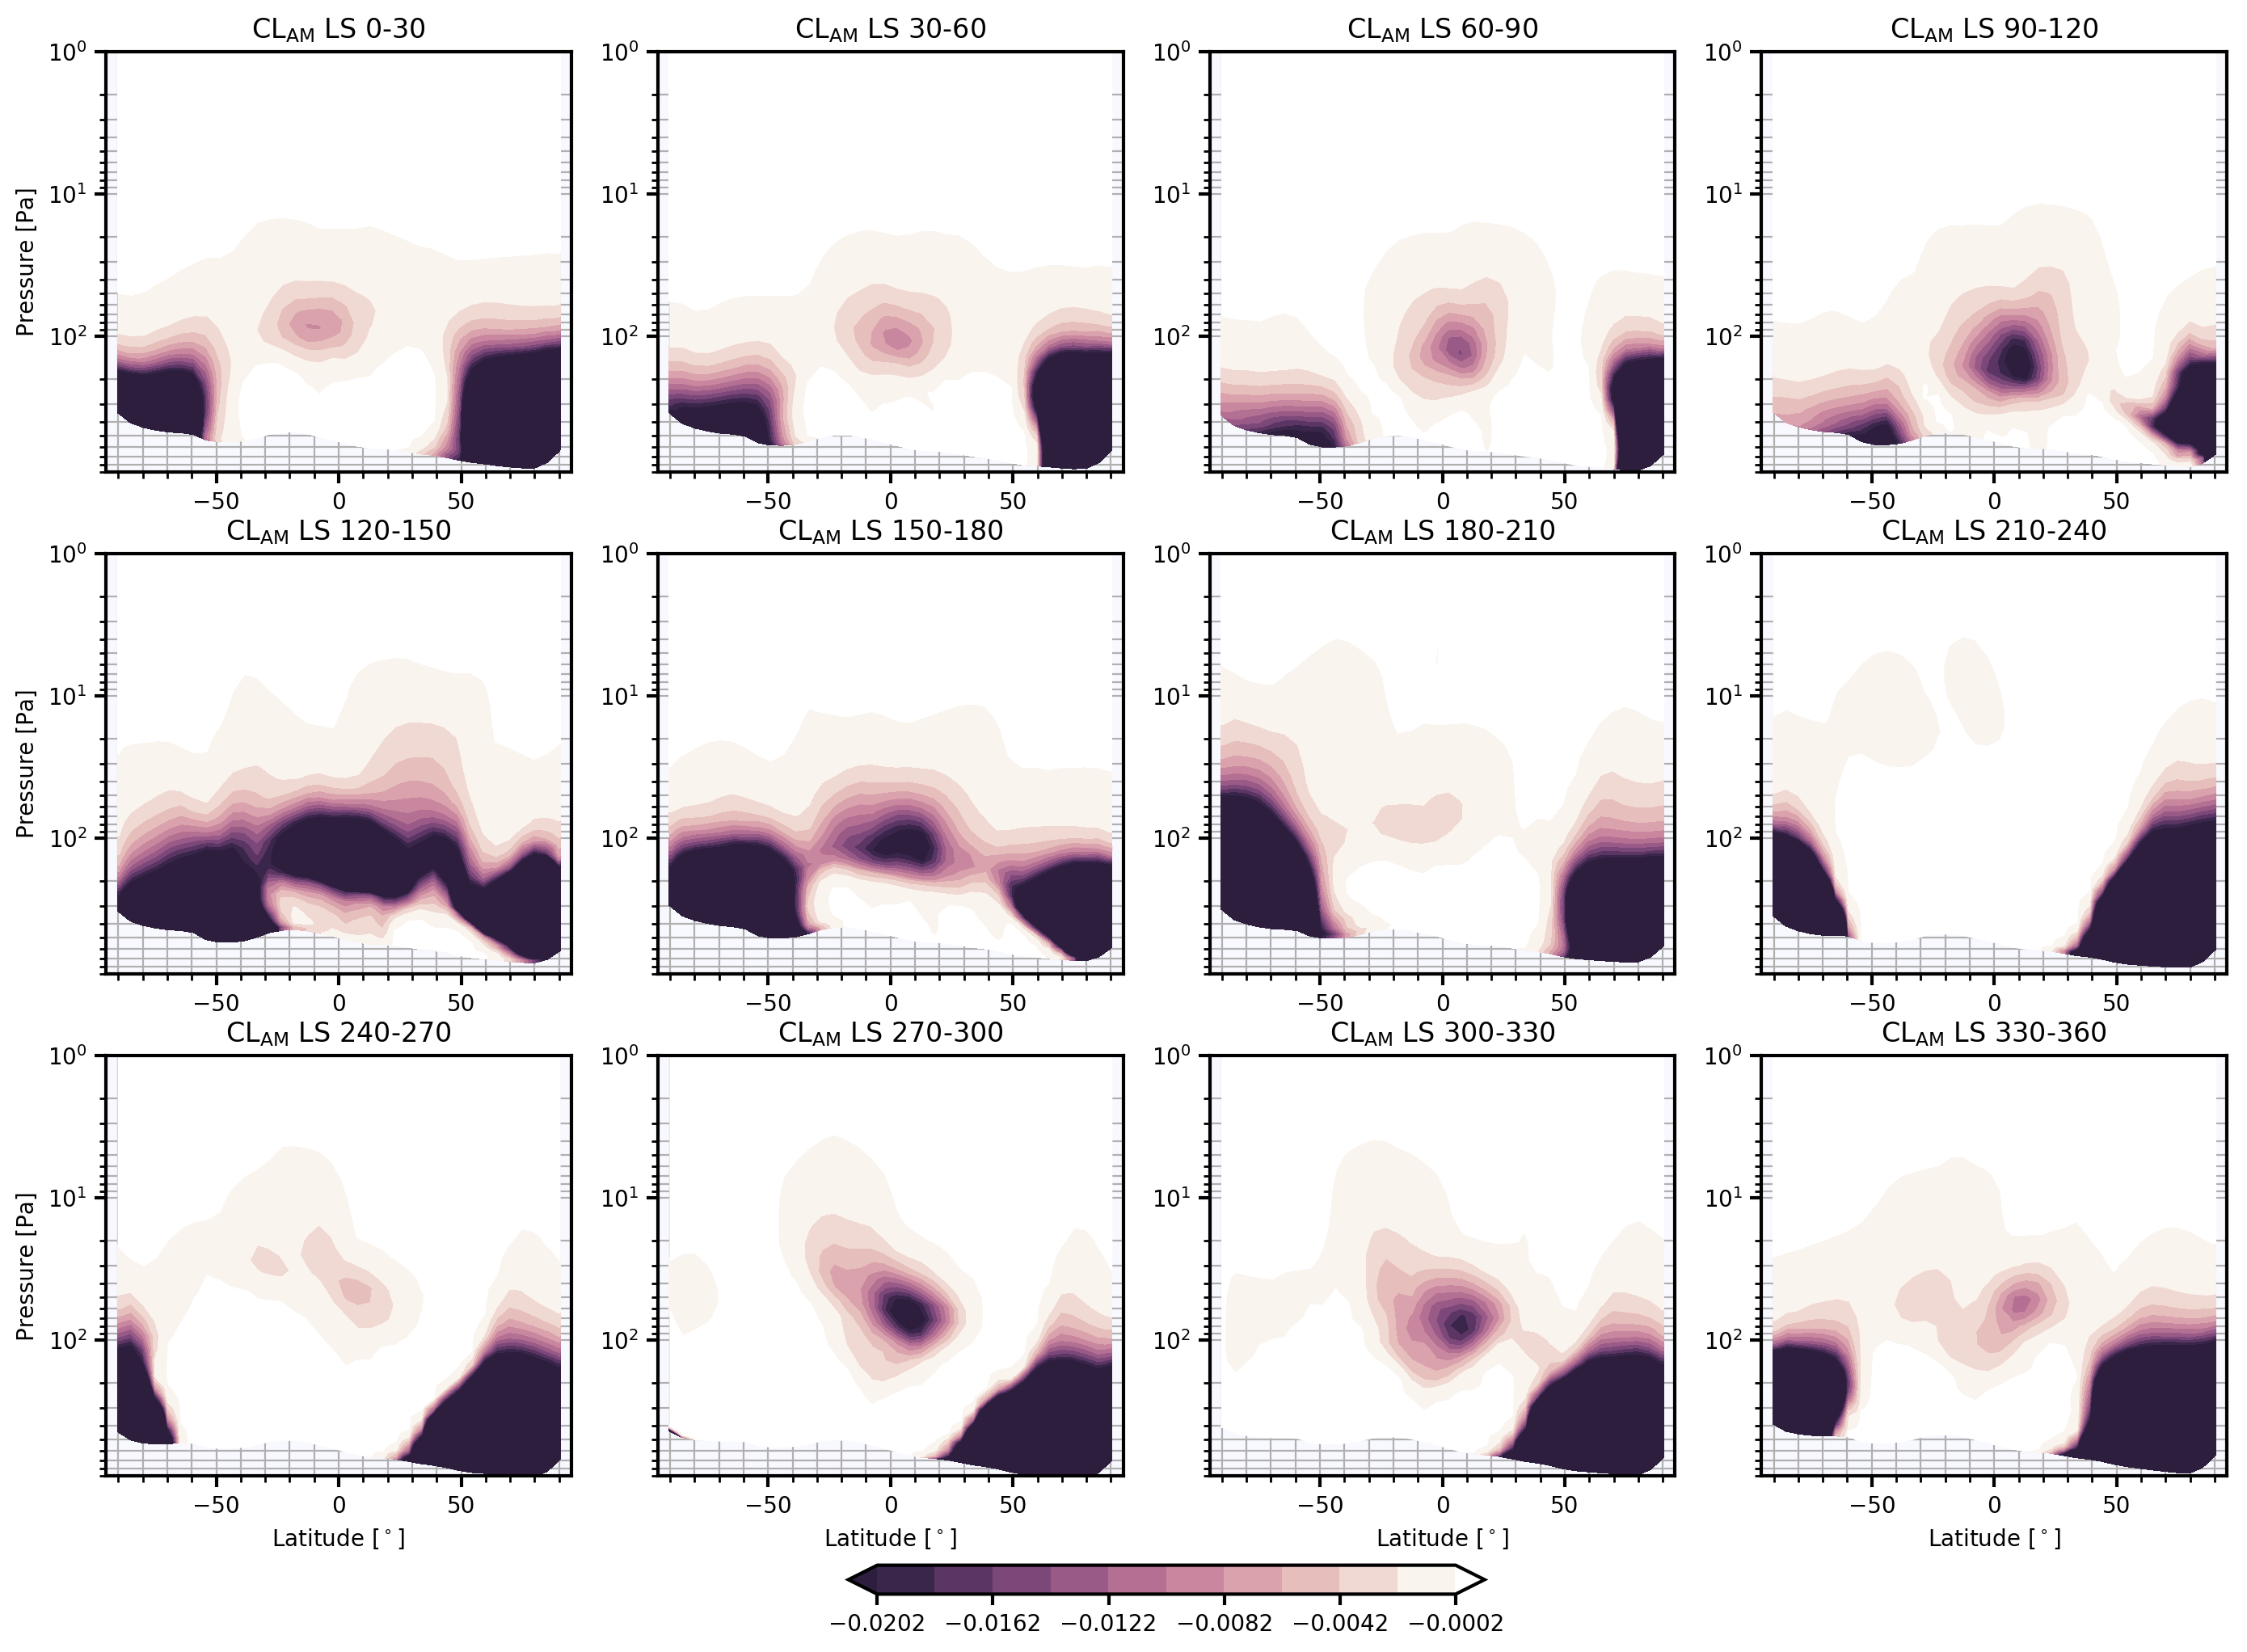

In [58]:

# sns.set_style("whitegrid")
zonal_plt_monthly(zonal_p, ls, zonal_cl_am, 'CL$_{\mathrm{AM}}$', linspace(-2.02e-2,-2e-4,11), norm=False, cmap=cmap)
# zonal_plt_monthly(zonal_p, ls, zonal_cl_pm, 'CL$_{\mathrm{PM}}$', linspace(-2.02e-2,-2e-4,11), norm=False, cmap=cmap)

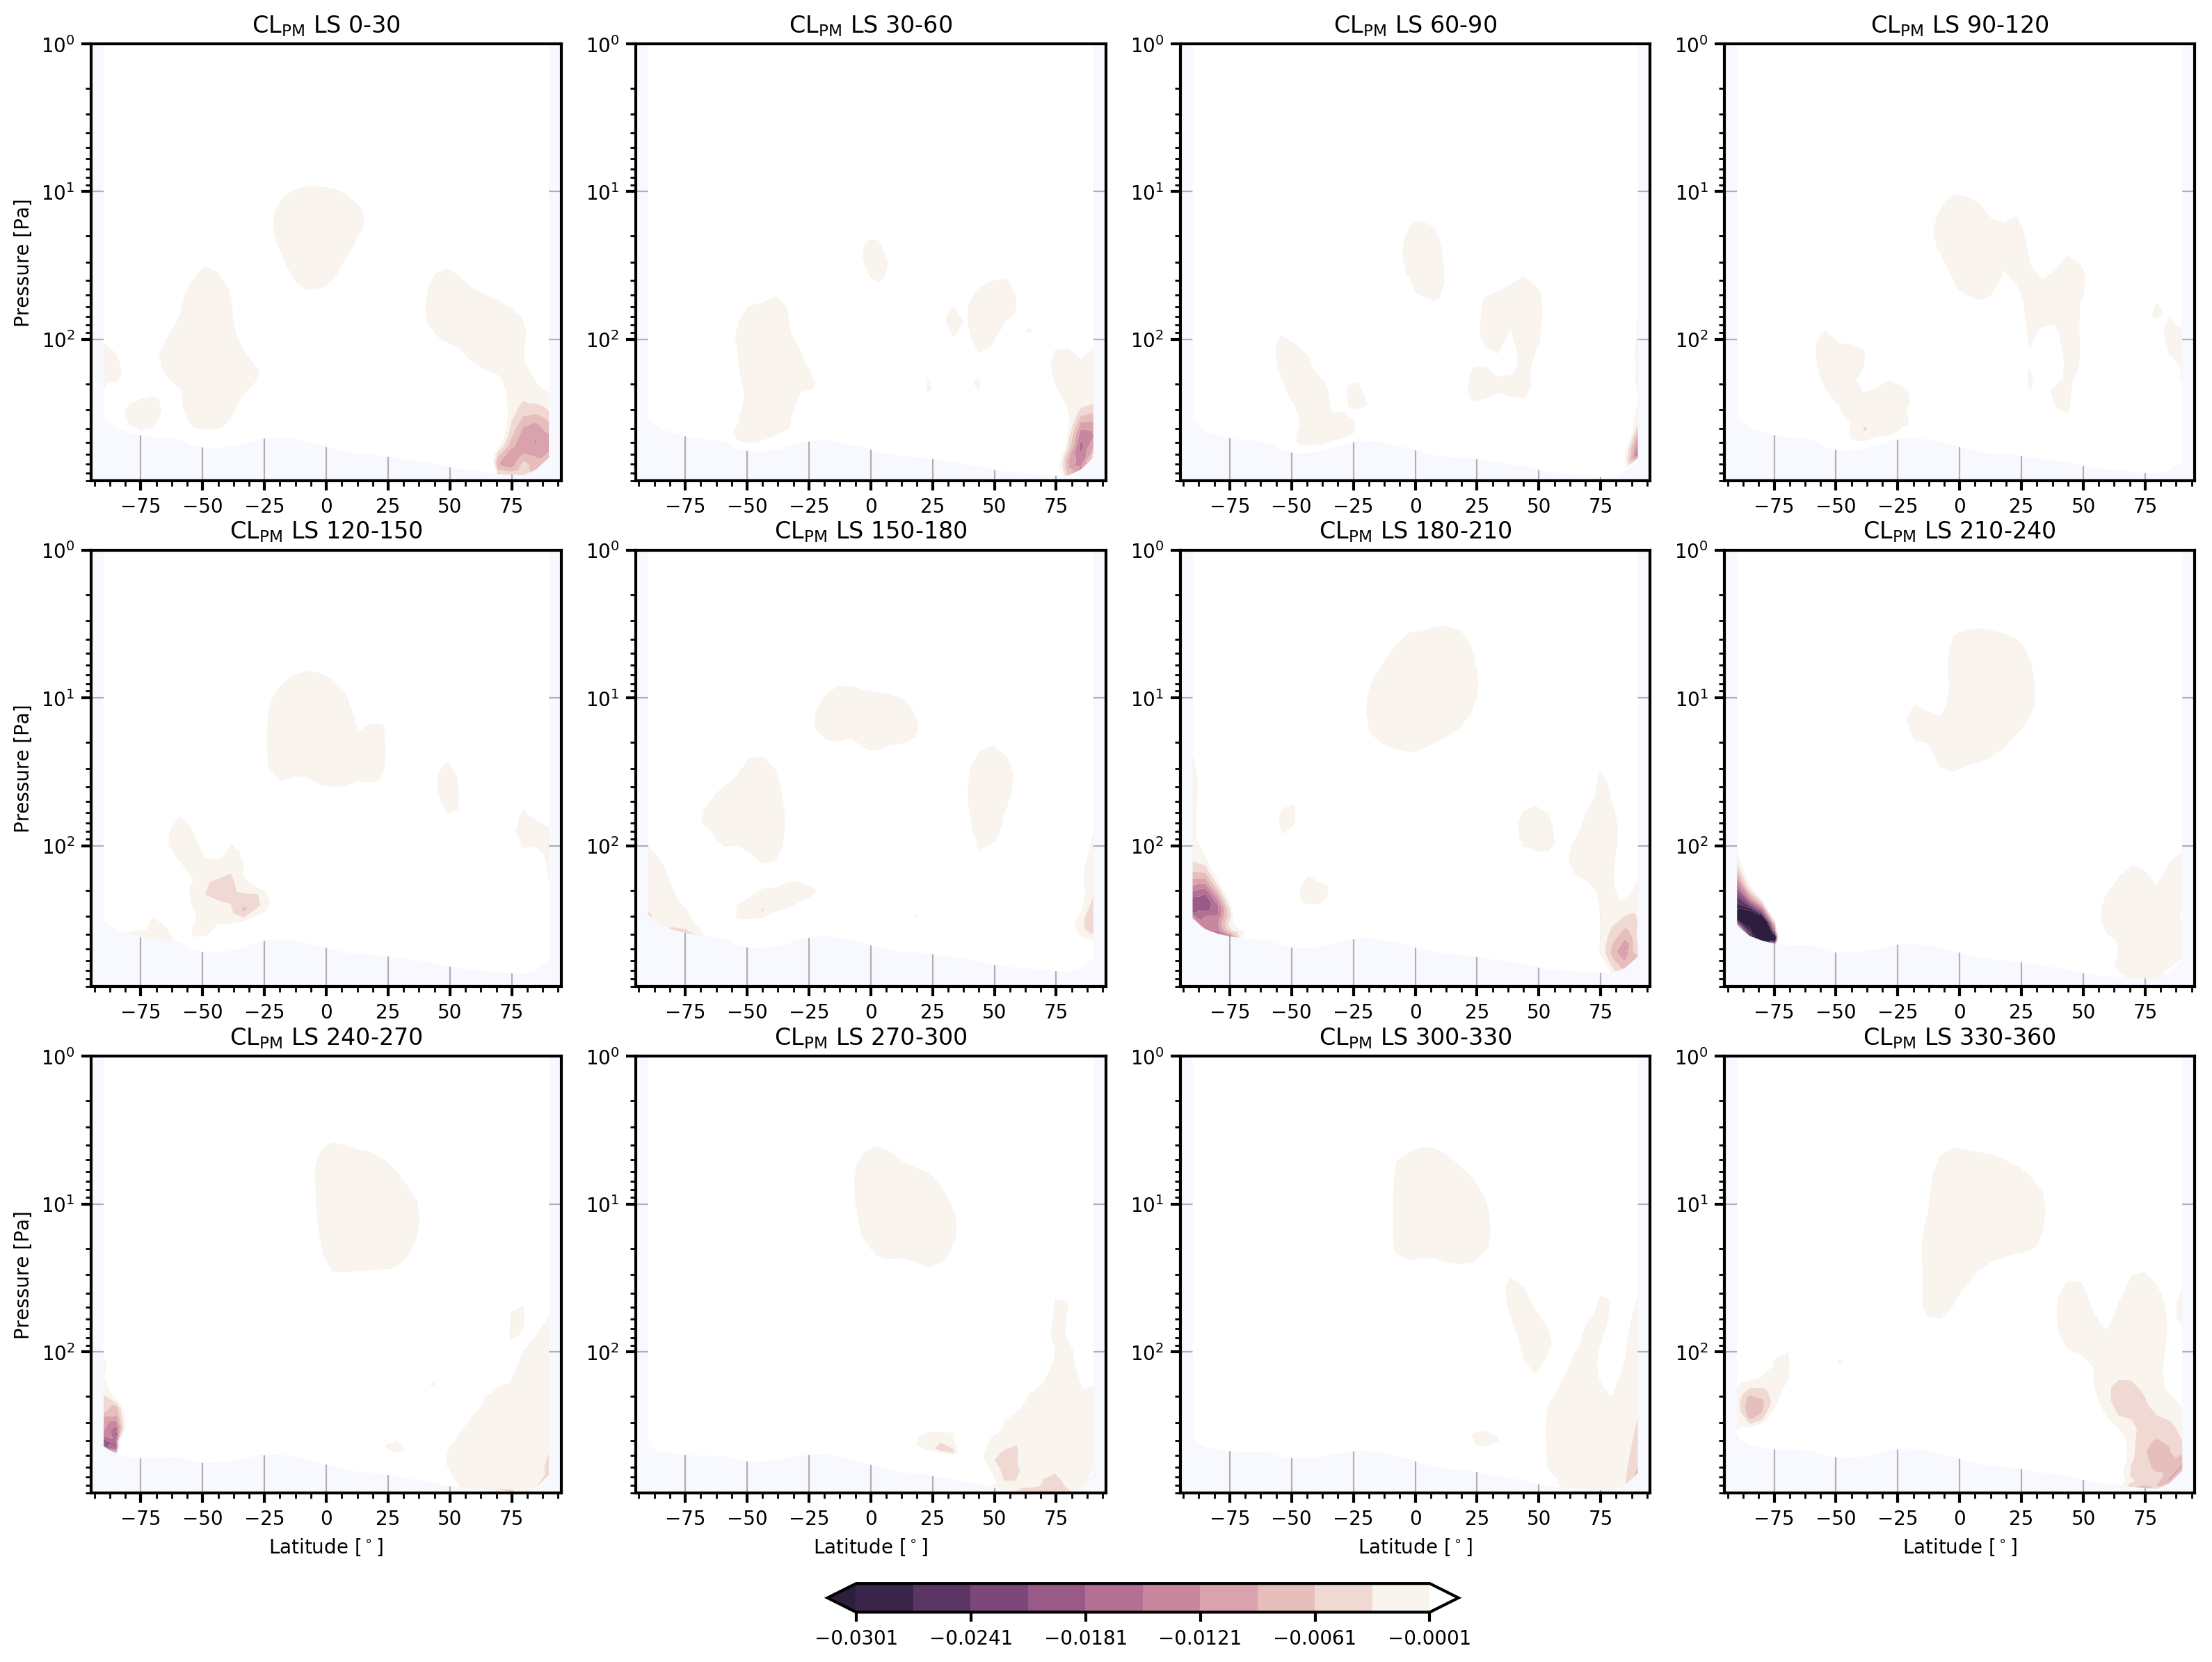

In [40]:
zonal_plt_monthly(zonal_p, ls, (zonal_cl_pm-zonal_cl_am)/2., 'CL$_{\mathrm{PM}}$',linspace(-3.01e-2,-1e-4,11), norm=False, cmap=cmap)

In [1]:
from netCDF4 import Dataset
data = Dataset('./r14p1_test.nc', mode='r')
c = data.variables['PH'][:]
print (c.shape)

(6000, 53, 11)


In [113]:
a = [[1,2,3],[6,8,6,6]]
b = [[1,3,4],[7,9,6,7]]
c=a+b
print(c)
vstack(c[0::2])

[[1, 2, 3], [6, 8, 6, 6], [1, 3, 4], [7, 9, 6, 7]]


array([[1, 2, 3],
       [1, 3, 4]])